# Test wind farm run with boundaries

In [1]:
# Add any possible locations of amr-wind-frontend here
amrwindfedirs = ['/ascldap/users/lcheung/wind_uq/amrwind-frontend/',
                 '/ccs/proj/cfd162/lcheung/amrwind-frontend/']
import sys, os, shutil
for x in amrwindfedirs: sys.path.insert(1, x)

# Load the libraries
import amrwind_frontend  as amrwind
import matplotlib.pyplot as plt
import numpy             as np
import math
import pandas as pd
import postproamrwindsample as ppsample
import time
import utm

# Also ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Make all plots inline 
%matplotlib inline

In [2]:
# Start the AMR-Wind case
case = amrwind.MyApp.init_nogui()

In [3]:
# Location of precursor run with boundary data
precursordir  = '/lustre/orion/cfd162/scratch/lcheung/ALCC_Frontier_WindFarm/MedWS_LowTI/precursor6_20kmX20km_5m.bndry_data'
precursorsetup= precursordir+'/MedWS_LowTI_Offshore_Stable_Precursor_20x20_bndrydata.inp'

# Location of farm run dir
farmrundir       = './rundir'
outputfile       = 'MedWS_LowTI_farmrun1.inp'
noturboutputfile = 'MedWS_LowTI_farmrun1_noturbs.inp'

verbose          = True
cwd              = os.getcwd()

# Go to the run directory
if not os.path.exists(farmrundir):
    os.makedirs(farmrundir)
os.chdir(farmrundir)

# Load the starting point
case.loadAMRWindInput(precursorsetup)

CANNOT update: ABLMeanBoussinesq use forcechange=True in setval()


OrderedDict()

In [4]:
tstart = 25000 #chk65000 16125
tstop  = tstart+900
textra = 0

In [5]:
# Set the time constants
case.setAMRWindInput('time.stop_time', tstop)
case.setAMRWindInput('time.fixed_dt', 0.02)
case.setAMRWindInput('time.max_step',  -1)

In [6]:
# Set the restart point
chkdir = precursordir+'/../precursor6_20kmX20km_5m/chk100000/'
case.setAMRWindInput('restart_file', os.path.realpath(chkdir))

In [7]:
# Set the boundary input file parameters
ablstatfile = precursordir+'/post_processing/abl_statistics100000.nc'
tavg        =  [25000, 25900] #[tstart, tstop]
#tavg        = [27473.2, 27473.2+600]
forcingdict = {'ablstatfile':ablstatfile, 'tavg':tavg}
inflowplanes= ['xlo', 'ylo'] #['ylo', 'xhi']
bndryfiles  = '/lustre/orion/cfd162/scratch/lcheung/ALCC_Frontier_WindFarm/MedWS_LowTI/precursor6_20kmX20km_5m.bndry_data/bndry_data.25000/' 
#precursordir+'/bndry_data'

In [8]:
case.boundaryplane_restart(bndryfiles=bndryfiles, 
                           forcingdict=forcingdict, 
                           inflowplanes=inflowplanes, 
                           checkpointdir=chkdir,
                           verbose=True)

SET ABL_bndry_io_mode = '1'
SET ABL_bndry_file = '/lustre/orion/cfd162/scratch/lcheung/ALCC_Frontier_WindFarm/MedWS_LowTI/precursor6_20kmX20km_5m.bndry_data/bndry_data.25000/'
SET ABL_bndry_planes = ['xlo', 'ylo']
SET is_periodicx = False
SET is_periodicy = False
SET xlo_type = 'mass_inflow'
SET xlo_density = 1.2456
SET xlo_temperature = 0.0
SET xlo_tke = 0.0
SET ylo_type = 'mass_inflow'
SET ylo_density = 1.2456
SET ylo_temperature = 0.0
SET ylo_tke = 0.0
SET xhi_type = 'pressure_outflow'
SET xhi_density = None
SET xhi_temperature = None
SET xhi_tke = None
SET yhi_type = 'pressure_outflow'
SET yhi_density = None
SET yhi_temperature = None
SET yhi_tke = None
SET BodyForce = True
SET BodyForce_magnitude = [-0.0004939247032316185, 0.0006911810921632622, 0.0]
SET ABLForcing = False
SET ABLMeanBoussinesq = True
SET wall_shear_stress_type = 'local'
SET checkpoint_start = 100000


## Set the turbine locations

In [9]:
# Rotates a point pt about origin orig   
# Here theta is measured w.r.t. the x-axis
def rotatepoint(pt, orig, theta):
    dx = pt[0]-orig[0]
    dy = pt[1]-orig[1]
    p2=[0.0, 0.0]
    p2[0] = dx*math.cos(theta) - dy*math.sin(theta) + orig[0]
    p2[1] = dx*math.sin(theta) + dy*math.cos(theta) + orig[1]
    return p2

def removeturbines(runcase):
    physics = runcase.getAMRWindInput('incflo.physics')
    if 'Actuator' in physics:
        physics.remove('Actuator')
        runcase.setAMRWindInput('physics', physics)
        print('SET incflo.physics: '+repr(runcase.getAMRWindInput('incflo.physics')))
    runcase.setAMRWindInput('ActuatorForcing', False)    
    runcase.listboxpopupwindict['listboxactuator'].deleteall()
    return

In [10]:
# Define some properties
rotorD = 240           # Rotor diameter
WS     = 10            # Wind speed, m/s
WDir   = 210           # Wind direction, degrees

# Farm properties
farm_rotate      = -45                          # Number of degrees to rotate turbine rows (relative to x-axis)

# ==== 50 turbine staggered arrangement ====
farm_title       = 'IEA 15MW, 28 turbine staggered arrangement'
# Turbine spacing
turb_LatSpacing  = 6   # lateral spacing, diameters
turb_LongSpacing = 6   # longitudinal spacing, diameters
# Define the rows
farmrowdict = [{'Nturb':5, 'rowoffset':3},
               {'Nturb':5, 'rowoffset':3},
               {'Nturb':5, 'rowoffset':3},
               {'Nturb':5, 'rowoffset':3},
               {'Nturb':5, 'rowoffset':3},
              ]

farmturb_orig    = [-2500, -2500]
farmL            = 10240.0
farm_domainsize  = [2*farmL, 2*farmL, 960.0]   # Farm domain size
farm_background_mesh = 5.0                     # Background mesh size [meters]

In [11]:
# Build the wind farm turbine positions
farmturb_xy = []
for irow, row in enumerate(farmrowdict):
    turb_y = irow*turb_LongSpacing*rotorD
    for iturb in range(row['Nturb']):
        turb_x = iturb*turb_LatSpacing*rotorD + row['rowoffset']*rotorD
        farmturb_xy.append([turb_x, turb_y])
farmturb_xy = np.array(farmturb_xy)

print("Total turbines = "+repr(len(farmturb_xy)))

# Recenter the farm to be at the origin
farmturb_0 = np.mean(farmturb_xy, axis=0)
farmturb_xy = np.array([x-farmturb_0 for x in farmturb_xy])
farmturb_xy = np.array([rotatepoint(pt, [0.0, 0.0], farm_rotate*np.pi/180.0) for pt in farmturb_xy])
farmturb_xy = np.array([x+farmturb_orig for x in farmturb_xy])

Total turbines = 25


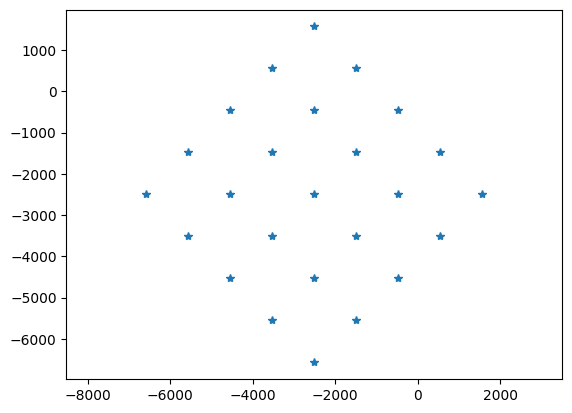

In [12]:
# Test plot
plt.plot(farmturb_xy[:,0], farmturb_xy[:,1], '*')
plt.axis('equal');

In [13]:
# Build the CSV input file of turbine layouts for amrwind-frontend
turbinescsv="""
# CSV file should have columns with
# name, x, y, type, yaw, hubheight, options
"""
rowformat="T%02i, %f, %f, IEA15MW_Joukowsky, , ,\n"
for iturb, xy in enumerate(farmturb_xy):
    turbinescsv += rowformat%(iturb, xy[0], xy[1])
case.setAMRWindInput('turbines_csvtextbox',  turbinescsv)

In [14]:
# Set up the domain 
case.setAMRWindInput('turbines_domainsize', farm_domainsize)
case.setAMRWindInput('turbines_backgroundmeshsize', farm_background_mesh)
case.setAMRWindInput('turbines_autocalccenter', False)
case.setAMRWindInput('turbines_farmcenter', [0, 0])
case.setAMRWindInput('turbines_deleteprev', True)
case.setAMRWindInput('turbines_createnewdomain', False)

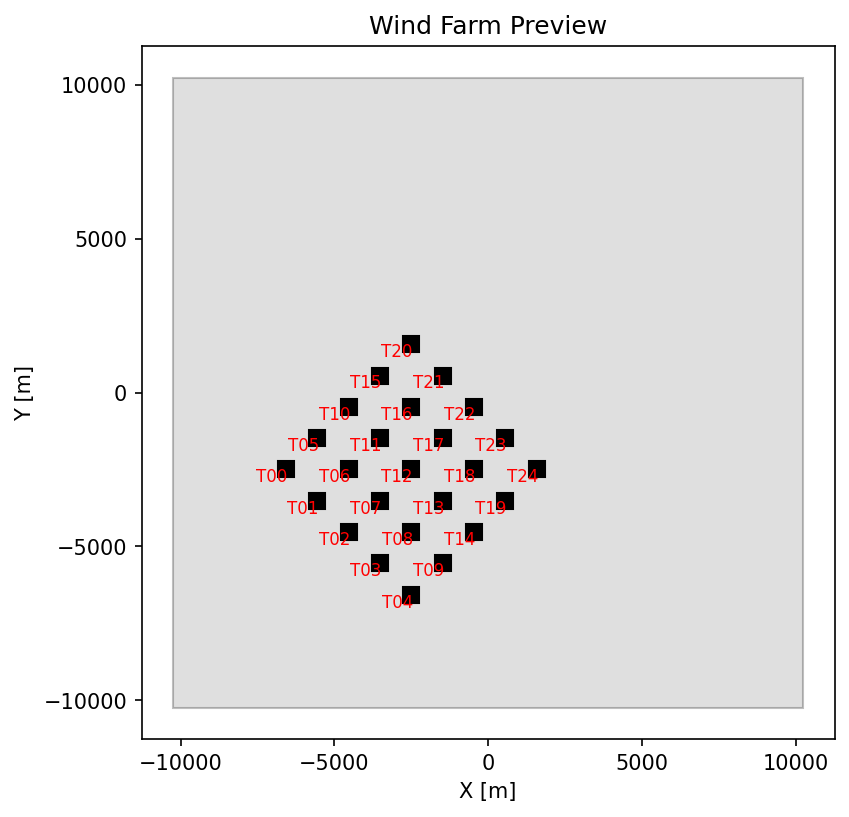

In [15]:
# Preview the turbine layout
fig, ax = plt.subplots(figsize=(6,6), facecolor='w', dpi=150)
case.turbines_previewAllTurbines(ax=ax)

In [16]:
case.turbines_createAllTurbines()

# Print out existing list of turbines, just to confirm that the turbines got made
print(case.listboxpopupwindict['listboxactuator'].getitemlist())

['T00', 'T01', 'T02', 'T03', 'T04', 'T05', 'T06', 'T07', 'T08', 'T09', 'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 'T16', 'T17', 'T18', 'T19', 'T20', 'T21', 'T22', 'T23', 'T24']


In [17]:
refinementcsv="""
# CSV file should have columns with
# level, upstream, downstream, lateral, below, above, options
level, upstream, downstream, lateral, below, above, options
0,     5000,     5000,       5500,    150,   200,     center:specified units:meter centerx:-2500 centery:-2500 centerz:150 name:A
"""
case.setAMRWindInput('refine_csvtextbox', refinementcsv)
case.setAMRWindInput('refine_deleteprev', True)
case.refine_createAllZones()

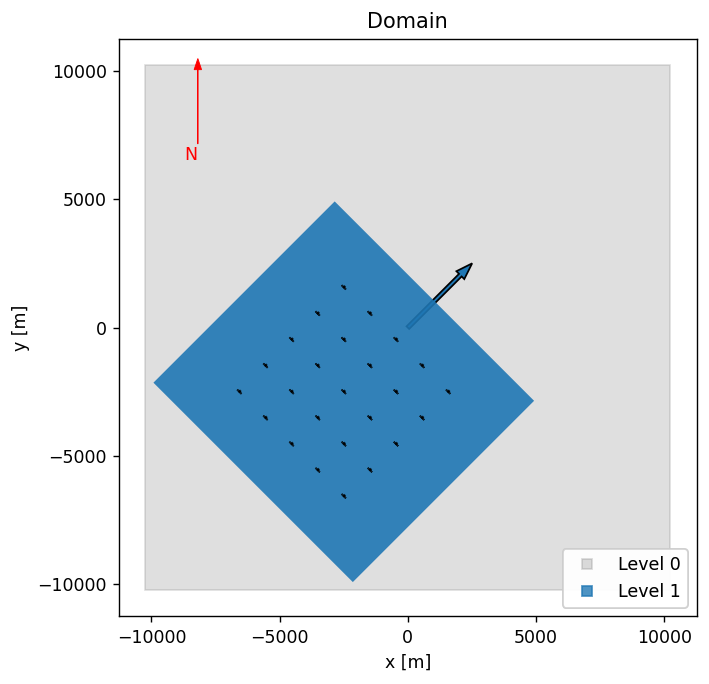

In [18]:
fig, ax = plt.subplots(figsize=(6,6), facecolor='w', dpi=125)

# Set any additional items to plot
case.popup_storteddata['plotdomain']['plot_turbines']        = case.listboxpopupwindict['listboxactuator'].getitemlist()
case.popup_storteddata['plotdomain']['plot_refineboxes']     = case.listboxpopupwindict['listboxtagging'].getitemlist()
case.popup_storteddata['plotdomain']['plot_sampleprobes']    = [] #['p_hub']
case.plotDomain(ax=ax)

In [19]:
# This will print out your mesh size & refinements
case.estimateMeshSize()

Refinement A: level 1: 2464000000 cells
ESTIMATED MESH SIZE
   Level       Ncells                      Cell Size
       0   3221225472                5.0 x 5.0 x 5.0
       1   2464000000                2.5 x 2.5 x 2.5
  TOTAL:   5685225472


## Add sampling
(Reuse previous sampling)

## Plot the domain

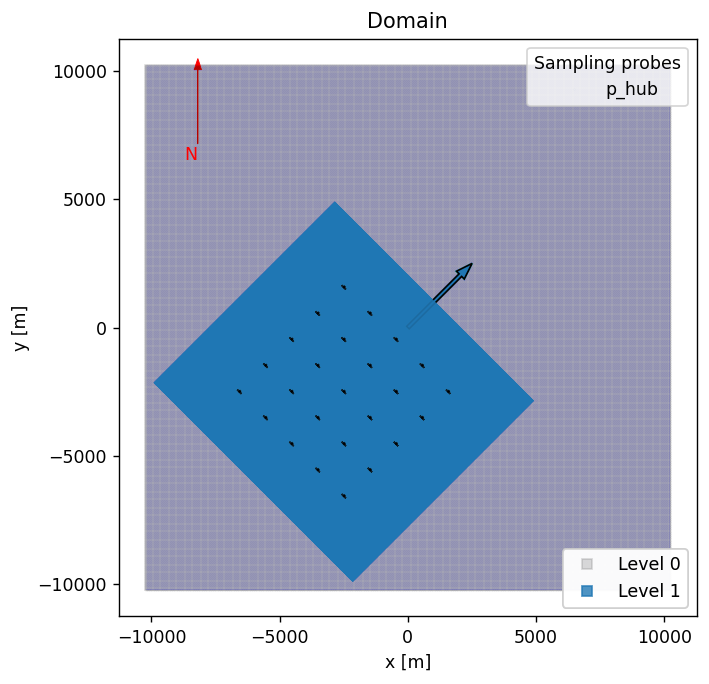

In [20]:
fig, ax = plt.subplots(figsize=(6,6), facecolor='w', dpi=125)

# Set any additional items to plot
case.popup_storteddata['plotdomain']['plot_refineboxes']     = case.listboxpopupwindict['listboxtagging'].getitemlist()
case.popup_storteddata['plotdomain']['plot_sampleprobes']    = ['p_hub']
case.popup_storteddata['plotdomain']['plot_sampleprobes_style'] = "{'markersize':0.01, 'marker':'.', 'linestyle':'None','alpha':0.25}"
case.popup_storteddata['plotdomain']['plot_chooseview']      = 'XY' 
case.plotDomain(ax=ax)

Text(0.5, 1.0, 'Initial Temp. Profile')

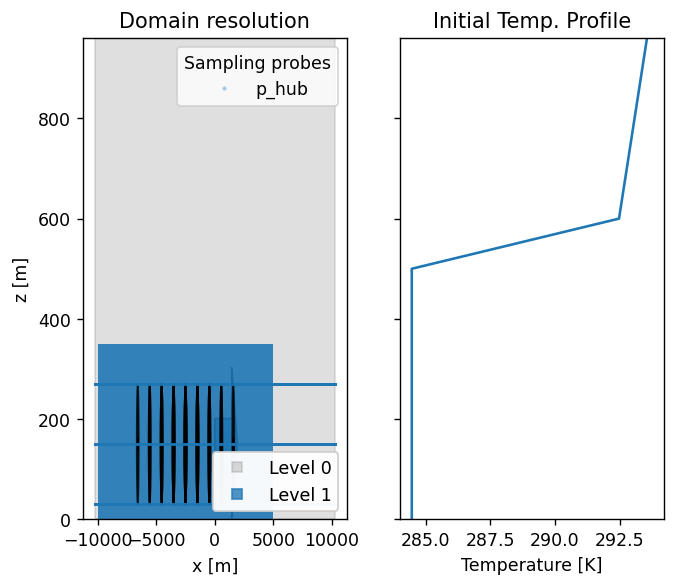

In [21]:
fig, axs = plt.subplots(1,2, figsize=(6,5), facecolor='w', dpi=125, sharey=True)

# Set any additional items to plot
case.popup_storteddata['plotdomain']['plot_refineboxes']     = case.listboxpopupwindict['listboxtagging'].getitemlist()
case.popup_storteddata['plotdomain']['plot_sampleprobes']    = ['p_hub']
case.popup_storteddata['plotdomain']['plot_chooseview']      = 'XZ' 
case.popup_storteddata['plotdomain']['plot_sampleprobes_style'] = "{'markersize':0.5, 'marker':'.', 'linestyle':'None','alpha':0.25}"
case.plotDomain(ax=axs[0])
axs[0].set_title('Domain resolution')
axs[0].axis('auto')
axs[0].set_ylim([0,960])

case.plotGenericProfile('ABL.temperature_values', 'ABL.temperature_heights', ax=axs[1])
axs[1].set_ylim([0,960])
#axs[1].axis('scaled')
axs[1].set_xlabel('Temperature [K]')
axs[1].set_title('Initial Temp. Profile')

In [22]:
# Check that all inputs are okay
check=case.validate()

-- Checking inputs --
[ PASS] max_level:           max_level = 1 >= 0
[ PASS] dt & CFL:            DT and CFL OK
[ PASS] Actuator physics:    incflo.physics and ICNS.source_terms OK for Actuators
[ SKIP] Actuator FST:T00     Not OpenFAST
[ SKIP] Actuator FST:T01     Not OpenFAST
[ SKIP] Actuator FST:T02     Not OpenFAST
[ SKIP] Actuator FST:T03     Not OpenFAST
[ SKIP] Actuator FST:T04     Not OpenFAST
[ SKIP] Actuator FST:T05     Not OpenFAST
[ SKIP] Actuator FST:T06     Not OpenFAST
[ SKIP] Actuator FST:T07     Not OpenFAST
[ SKIP] Actuator FST:T08     Not OpenFAST
[ SKIP] Actuator FST:T09     Not OpenFAST
[ SKIP] Actuator FST:T10     Not OpenFAST
[ SKIP] Actuator FST:T11     Not OpenFAST
[ SKIP] Actuator FST:T12     Not OpenFAST
[ SKIP] Actuator FST:T13     Not OpenFAST
[ SKIP] Actuator FST:T14     Not OpenFAST
[ SKIP] Actuator FST:T15     Not OpenFAST
[ SKIP] Actuator FST:T16     Not OpenFAST
[ SKIP] Actuator FST:T17     Not OpenFAST
[ SKIP] Actuator FST:T18     Not OpenFAST
[ SKIP

In [23]:
# Write the input file
print(case.writeAMRWindInput('MedWS_LowTI_Offshore_Stable_Farmrun1_20x20_Aligned.inp'))

# --- Simulation time control parameters ---
time.stop_time                           = 25900.0             # Max (simulated) time to evolve [s]
time.max_step                            = -1                  
time.fixed_dt                            = 0.1                 # Fixed timestep size (in seconds). If negative, then time.cfl is used
time.checkpoint_interval                 = 1000                
time.checkpoint_start                    = 100000              
incflo.physics                           = ABL Actuator        # List of physics models to include in simulation.
incflo.verbose                           = 3                   
io.check_file                            = chk                 
io.restart_file                          = /lustre/orion/cfd162/scratch/lcheung/ALCC_Frontier_WindFarm/MedWS_LowTI/precursor6_20kmX20km_5m/chk100000
incflo.use_godunov                       = true                
incflo.godunov_type                      = weno_z              
turbulence